In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:0000:0100:01


  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.9.0
    Uninstalling tensorflow-gpu-2.9.0:
      Successfully uninstalled tensorflow-gpu-2.9.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


2022-07-05 18:33:34.013760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 18:33:34.013792: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-07-05 18:33:36.800446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 18:33:37.668453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 18:33:37.668603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-05 18:33:37.668718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Danmini Doorbell Data Pre-Processing

In [6]:
# Benign traffic

dd_benign = pd.read_csv('../nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

columns = list(df_dd_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)

# Mirai

dd_mirai_ack = pd.read_csv('../nbaiot/Danmini_Doorbell/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('../nbaiot/Danmini_Doorbell/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('../nbaiot/Danmini_Doorbell/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('../nbaiot/Danmini_Doorbell/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('../nbaiot/Danmini_Doorbell/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite

dd_bashlite_combo = pd.read_csv('../nbaiot/Danmini_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('../nbaiot/Danmini_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('../nbaiot/Danmini_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('../nbaiot/Danmini_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('../nbaiot/Danmini_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_dd_benign_norm = scaler.fit_transform(df_dd_benign)

df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [6]:
# Train set

len_benign = len(df_dd_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_dd_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_dd_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_dd_miraiack_norm
X_test_mirai_scan = df_dd_miraiscan_norm
X_test_mirai_syn = df_dd_miraisyn_norm
X_test_mirai_udp = df_dd_miraiudp_norm
X_test_mirai_udpplain = df_dd_miraiudpplain_norm
X_test_bashlite_combo = df_dd_bashlitecombo_norm
X_test_bashlite_junk = df_dd_bashlitejunk_norm
X_test_bashlite_scan = df_dd_bashlitescan_norm
X_test_bashlite_tcp = df_dd_bashlitetcp_norm
X_test_bashlite_udp = df_dd_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

983615


In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 800
learning_rate = 0.0001
batch_size = 82
anomaly_threshold = 0.042
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 34683 samples
Epoch 1/800


2022-04-26 21:52:11.151167: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


34683/34683 [==============================] - 1s 24us/sample - loss: 309.8200
Epoch 2/800
34683/34683 [==============================] - 1s 16us/sample - loss: 220.6229
Epoch 3/800
34683/34683 [==============================] - 1s 16us/sample - loss: 131.9441
Epoch 4/800
34683/34683 [==============================] - 1s 17us/sample - loss: 60.1418
Epoch 5/800
34683/34683 [==============================] - 1s 17us/sample - loss: 29.3265
Epoch 6/800
34683/34683 [==============================] - 1s 16us/sample - loss: 20.6489
Epoch 7/800
34683/34683 [==============================] - 1s 16us/sample - loss: 16.5827
Epoch 8/800
34683/34683 [==============================] - 1s 16us/sample - loss: 14.3596
Epoch 9/800
34683/34683 [==============================] - 1s 16us/sample - loss: 12.9048
Epoch 10/800
34683/34683 [==============================] - 1s 17us/sample - loss: 11.8385
Epoch 11/800
34683/34683 [==============================] - 1s 17us/sample - loss: 11.0641
Epoch 12/800
3468

34683/34683 [==============================] - 1s 19us/sample - loss: 2.5279
Epoch 93/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.5103
Epoch 94/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.5226
Epoch 95/800
34683/34683 [==============================] - 1s 20us/sample - loss: 2.5087
Epoch 96/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4959
Epoch 97/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4835
Epoch 98/800
34683/34683 [==============================] - 1s 20us/sample - loss: 2.4718
Epoch 99/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4812
Epoch 100/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4576
Epoch 101/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4703
Epoch 102/800
34683/34683 [==============================] - 1s 19us/sample - loss: 2.4537
Epoch 103/800
34683/

34683/34683 [==============================] - 1s 17us/sample - loss: 2.1546
Epoch 273/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1461
Epoch 274/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1521
Epoch 275/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1545
Epoch 276/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1396
Epoch 277/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1483
Epoch 278/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1521
Epoch 279/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1365
Epoch 280/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1304
Epoch 281/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1357
Epoch 282/800
34683/34683 [==============================] - 1s 17us/sample - loss: 2.1333
Epoch 283/800

34683/34683 [==============================] - 1s 15us/sample - loss: 2.0835
Epoch 453/800
34683/34683 [==============================] - 1s 15us/sample - loss: 2.0789
Epoch 454/800
34683/34683 [==============================] - 1s 15us/sample - loss: 2.0788
Epoch 455/800
34683/34683 [==============================] - 0s 14us/sample - loss: 2.0951
Epoch 456/800
34683/34683 [==============================] - 1s 15us/sample - loss: 2.0841
Epoch 457/800
34683/34683 [==============================] - 1s 14us/sample - loss: 2.0678
Epoch 458/800
34683/34683 [==============================] - 1s 14us/sample - loss: 2.0822
Epoch 459/800
34683/34683 [==============================] - 1s 15us/sample - loss: 2.0927
Epoch 460/800
34683/34683 [==============================] - 0s 14us/sample - loss: 2.0913
Epoch 461/800
34683/34683 [==============================] - 0s 14us/sample - loss: 2.0762
Epoch 462/800
34683/34683 [==============================] - 0s 14us/sample - loss: 2.0784
Epoch 463/800

34683/34683 [==============================] - 0s 13us/sample - loss: 2.0494
Epoch 633/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0573
Epoch 634/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0495
Epoch 635/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0498
Epoch 636/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0424
Epoch 637/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0500
Epoch 638/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0537
Epoch 639/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0548
Epoch 640/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0582
Epoch 641/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0455
Epoch 642/800
34683/34683 [==============================] - 0s 13us/sample - loss: 2.0457
Epoch 643/800

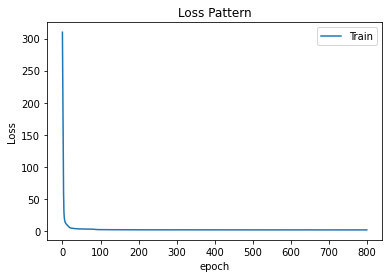

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 32.727320432662964
[False False  True ...  True  True  True]


0.9850134453012611

In [15]:
print(len(X_test_VAE))

983615


## Metrics

In [16]:
sys.stdout = open("../Results/damini_doorbell.txt", "a")

print(" ==== Test " + str(number_features) + " features - Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'